# Tracking through a simple lattice

In this example, we create a custom lattice and track a beam through it. We start with some imports.


In [1]:
import torch

import cheetah

Lattices in _Cheetah_ are represented by `Segments`. A `Segment` is created as follows.


In [2]:
segment = cheetah.Segment(
    elements=[
        cheetah.Drift(length=torch.tensor(0.175)),
        cheetah.Quadrupole(length=torch.tensor(0.122), name="AREAMQZM1"),
        cheetah.Drift(length=torch.tensor(0.428)),
        cheetah.Quadrupole(length=torch.tensor(0.122), name="AREAMQZM2"),
        cheetah.Drift(length=torch.tensor(0.204)),
        cheetah.VerticalCorrector(length=torch.tensor(0.02), name="AREAMCVM1"),
        cheetah.Drift(length=torch.tensor(0.204)),
        cheetah.Quadrupole(length=torch.tensor(0.122), name="AREAMQZM3"),
        cheetah.Drift(length=torch.tensor(0.179)),
        cheetah.HorizontalCorrector(length=torch.tensor(0.02), name="AREAMCHM1"),
        cheetah.Drift(length=torch.tensor(0.45)),
        cheetah.Screen(name="AREABSCR1"),
    ]
)

Alternatively you can load lattices from Cheetah's variant of LatticeJSON or convert them from an Ocelot cell

```python
lattice_json_segment = cheetah.Segment.from_lattice_json("lattice_file.json")
segment = cheetah.Segment.from_ocelot(cell)
```


**Note** that many values must be passed to lattice elements as `torch.Tensor`s. This is because _Cheetah_ uses automatic differentiation to compute the gradient of the beam position at the end of the lattice with respect to the element strengths. This is necessary for gradient-based magnet setting optimisation.

Named lattice elements (i.e. elements that were given a `name` keyword argument) can be accessed by name and their parameters changed like so.


In [3]:
segment.AREAMQZM1.k1 = torch.tensor(8.2)
segment.AREAMQZM2.k1 = torch.tensor(-14.3)
segment.AREAMCVM1.angle = torch.tensor(9e-5)
segment.AREAMQZM3.k1 = torch.tensor(3.142)
segment.AREAMCHM1.angle = torch.tensor(-1e-4)

Cheetah has two different beam classes: `ParticleBeam` and `ParameterBeam`. The former tracks multiple individual macroparticles for high-fidelity results, while the latter tracks the parameters of a particle distribution to save on compute time and memory.

You can create a beam manually by specifying the beam parameters of a Gaussian distributed beam


In [4]:
parameter_beam = cheetah.ParameterBeam.from_twiss(beta_x=torch.tensor(3.14))
particle_beam = cheetah.ParticleBeam.from_twiss(
    beta_x=torch.tensor(3.14), beta_y=torch.tensor(42.0), num_particles=10_000
)

or load beams from other codes and standards, including openPMD, Ocelot and Astra.


In [5]:
astra_beam = cheetah.ParticleBeam.from_astra(
    "../../tests/resources/ACHIP_EA1_2021.1351.001"
)

In order to track a beam through the segment, simply call the segment's `track` method.


In [6]:
outgoing_beam = segment.track(astra_beam)

You may plot a segment with reference particle traces by calling


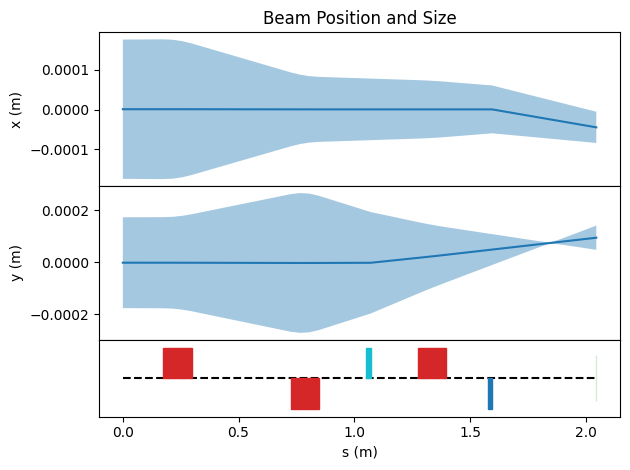

In [7]:
segment.plot_overview(incoming=astra_beam, resolution=0.05)

where the keyword argument `incoming` is the incoming beam represented by the reference particles.


You can also visualise your segment in 3D. **Note** that this requires that you installed Cheetah as `pip install cheetah-accelerator[3d]`.

Use `mesh.show` to view the mesh and `mesh.export` to export it to a file.


In [8]:
mesh, _ = segment.to_mesh(
    cuteness={cheetah.HorizontalCorrector: 2.0, cheetah.VerticalCorrector: 2.0}
)
mesh.show()

In [11]:
mesh.export(file_obj="my_first_cheetah_mesh.glb", file_type="glb")

b'glTF\x02\x00\x00\x00\x14\x9c\x10\x00h\x05\x00\x00JSON{"scene":0,"scenes":[{"nodes":[0]}],"asset":{"version":"2.0","generator":"https://github.com/mikedh/trimesh"},"accessors":[{"componentType":5125,"type":"SCALAR","bufferView":0,"count":119682,"max":[30402],"min":[0]},{"componentType":5126,"type":"VEC3","byteOffset":0,"bufferView":1,"count":30403,"max":[0.13898545503616333,0.13898545503616333,2.132875919342041],"min":[-0.47503897547721863,-0.13898545503616333,0.17488659918308258]},{"componentType":5126,"type":"VEC2","byteOffset":0,"bufferView":4,"count":30403,"max":[0.679765522480011,0.7279947996139526],"min":[0.035157211124897,0.7006510496139526]}],"meshes":[{"name":"geometry_0","extras":{},"primitives":[{"attributes":{"POSITION":1,"TEXCOORD_0":2},"indices":0,"mode":4,"material":0}]}],"images":[{"bufferView":2,"mimeType":"image/png"},{"bufferView":3,"mimeType":"image/png"}],"textures":[{"source":0},{"source":1}],"materials":[{"pbrMetallicRoughness":{"baseColorTexture":{"index":0},"m